<a href="https://colab.research.google.com/github/ENRICOROBLESDELRIO/data_boot_camp_final_project/blob/raquel_branch/Analisis_Raquel_Logistic_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data base set up


In [1]:
# Libraries and dependencies

import numpy as np
import pandas as pd
import seaborn as sns
import math
import psycopg2
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from google.colab import files
from sqlalchemy import create_engine

## Import for models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Google Cloud SQL connexion:
# Code taken from: https://stackoverflow.com/questions/53180140/how-to-access-cloud-sql-from-google-colab
!gcloud auth login
!gcloud config set project endeavor-intelligence-unit
!gcloud sql instances describe finalprojectdb


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=LbkSKZtiJGeHsywrPQD25kv4QwEqNc&prompt=consent&access_type=offline&code_challenge=-Cm3_9LFg8m23B9B_X8fF2RpPeNJfBGKocAB4yK2aI8&code_challenge_method=S256

Enter verification code: 4/1AX4XfWiI9hXUVb5am4mgugr7tQq5Pj92P2q3vEswF0P4tg3wtZjnSNb0-cg

You are now logged in as [racvbs@gmail.com].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Updated property [core/project].
ERROR: (gcloud.sql.instances.describe) There was no instance 

In [3]:
# download and initialize the psql proxy
!wget https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64 -O cloud_sql_proxy
!chmod +x cloud_sql_proxy

# "connectionName" is from the previous block
!nohup ./cloud_sql_proxy -instances="endeavor-intelligence-unit:northamerica-northeast2:finalprojectdb"=tcp:5432 &
!sleep 30s

--2021-11-21 00:27:00--  https://dl.google.com/cloudsql/cloud_sql_proxy.linux.amd64
Resolving dl.google.com (dl.google.com)... 172.217.203.136, 172.217.203.91, 172.217.203.190, ...
Connecting to dl.google.com (dl.google.com)|172.217.203.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16638816 (16M) [application/octet-stream]
Saving to: ‘cloud_sql_proxy’

cloud_sql_proxy     100%[===================>]  15.87M  --.-KB/s    in 0.07s   

2021-11-21 00:27:00 (215 MB/s) - ‘cloud_sql_proxy’ saved [16638816/16638816]

nohup: appending output to 'nohup.out'


In [4]:
# Connection to protect access and users to the database: 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Connection to the file with user and access to the database: 

from google.colab import files

with open('/content/drive/MyDrive/Final_project/Second_Deliverable/key_config.txt', "r") as file:
    FileasList = file.readlines()
    username = FileasList[0]
    password = FileasList[1]

    new_line = []
    # Loop through the file
    for i in FileasList:
        # Get rid of any new lines ("enter")
        i = i.replace("\n", "")
        # Add the cleaned data to the new_line list
        new_line.append(i)
    # Set the username to be the first object
    username = new_line[0]
    # Set the password to be the second object
    password = new_line[1]
    # Set the host to be the third object
    host = new_line[2]
    # Set the port to be the four object
    port = new_line[3]
    # Set the database to be the five object
    database = new_line[4]

In [6]:
# Connexion throught psycopg2 Google Cloud SQL data base

conn = psycopg2.connect(
    host=host, port=port, database=database,
    user=username, password=password)

## Cleaning

In [7]:
# Query to connect with SQL data base
SQL_Query = pd.read_sql_query('''select * FROM "companies" ''', conn)
companies_df = pd.DataFrame(SQL_Query)
companies_df.head(20)

,id_company,foundation_year,category,first_r_year,first_r_amount,last_funding_year,amount_last_funding,month_since_last_funding,number_employees,increase_employees,number_investors,current_status,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_year,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_year,dp_last_round_amount,dp_years_operating,max_manager_exp,max_clevel_exp,max_engineering_exp,max_sales_exp,max_finance_exp,max_human_capital_exp,max_consulting_exp,max_founder_exp,max_number_of_startups,max_gender,max_foreing_studies,max_foreing_work_experience,max_foreing_founder,max_dp_years_of_experience,max_dp_years_of_experience_as_entreprenuer,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,mean_manager_exp,mean_clevel_exp,mean_engineering_exp,mean_sales_exp,mean_finance_exp,mean_human_capital_exp,mean_consulting_exp,mean_founder_exp,mean_number_of_startups,mean_gender,mean_foreing_studies,mean_foreing_work_experience,mean_foreing_founder,mean_dp_years_of_experience,mean_dp_years_of_experience_as_entreprenuer
0,3.0,2017.0,0.0,2017.0,1400000.0,2017.0,1400000.0,48.0,33.0,8.0,3.0,1.0,4.0,0.0,0.0,0.0,2017.0,1.0,1400000.0,1400000.0,2017.0,1400000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,12.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,0.0,0.0,22.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,7.0
1,7.0,2018.0,0.0,2018.0,10500.0,2018.0,10500.0,36.0,10.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2018.0,1.0,10500.0,10500.0,2018.0,10500.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0
2,10.0,2015.0,0.0,2015.0,200000.0,2015.0,200000.0,72.0,11.0,14.0,1.0,1.0,6.0,0.0,0.0,0.0,2015.0,1.0,200000.0,200000.0,2015.0,200000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0
3,23.0,2013.0,0.0,2013.0,150000.0,2021.0,40000000.0,0.0,1001.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2021.0,5.0,54800000.0,40000000.0,2021.0,40000000.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0
4,51.0,2018.0,0.0,2018.0,20000.0,2018.0,20000.0,36.0,10.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,2018.0,1.0,20000.0,20000.0,2018.0,20000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0
5,64.0,2017.0,0.0,2017.0,50000.0,2017.0,50000.0,48.0,10.0,3.0,1.0,1.0,4.0,0.0,0.0,0.0,2017.0,1.0,50000.0,50000.0,2017.0,50000.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
6,93.0,2011.0,0.0,2011.0,30000.0,2011.0,30000.0,120.0,10.0,0.0,1.0,1.0,10.0,0.0,0.0,0.0,2011.0,1.0,30000.0,30000.0,2011.0,30000.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,6.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,0.0,1.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0
7,129.0,2020.0,0.0,2020.0,33000.0,2020.0,33000.0,12.0,10.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,2020.0,1.0,33000.0,33000.0,2020.0,33000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,25.0,20.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,25.0,20.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,25.0,20.0
8,141.0,2015.0,0.0,2015.0,250000.0,2021.0,15000000.0,0.0,130.0,98.0,0.0,1.0,0.0,0.0,1.0,1.0,2021.0,6.0,25500000.0,1500000

In [8]:
# data types
companies_df.dtypes

id_company                                     float64
foundation_year                                float64
category                                       float64
first_r_year                                   float64
first_r_amount                                 float64
                                                ...   
mean_foreing_studies                           float64
mean_foreing_work_experience                   float64
mean_foreing_founder                           float64
mean_dp_years_of_experience                    float64
mean_dp_years_of_experience_as_entreprenuer    float64
Length: 68, dtype: object

In [9]:
# Is NA
companies_df.isna().sum()

id_company                                     0
foundation_year                                0
category                                       0
first_r_year                                   0
first_r_amount                                 0
                                              ..
mean_foreing_studies                           0
mean_foreing_work_experience                   0
mean_foreing_founder                           0
mean_dp_years_of_experience                    0
mean_dp_years_of_experience_as_entreprenuer    0
Length: 68, dtype: int64

In [10]:
# Counts
companies_df.count()

id_company                                     510
foundation_year                                510
category                                       510
first_r_year                                   510
first_r_amount                                 510
                                              ... 
mean_foreing_studies                           510
mean_foreing_work_experience                   510
mean_foreing_founder                           510
mean_dp_years_of_experience                    510
mean_dp_years_of_experience_as_entreprenuer    510
Length: 68, dtype: int64

In [11]:
# Drop the null columns where all values are null
companies_df = companies_df.dropna(axis='columns', how='all')
companies_df.head()

,id_company,foundation_year,category,first_r_year,first_r_amount,last_funding_year,amount_last_funding,month_since_last_funding,number_employees,increase_employees,number_investors,current_status,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_year,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_year,dp_last_round_amount,dp_years_operating,max_manager_exp,max_clevel_exp,max_engineering_exp,max_sales_exp,max_finance_exp,max_human_capital_exp,max_consulting_exp,max_founder_exp,max_number_of_startups,max_gender,max_foreing_studies,max_foreing_work_experience,max_foreing_founder,max_dp_years_of_experience,max_dp_years_of_experience_as_entreprenuer,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,mean_manager_exp,mean_clevel_exp,mean_engineering_exp,mean_sales_exp,mean_finance_exp,mean_human_capital_exp,mean_consulting_exp,mean_founder_exp,mean_number_of_startups,mean_gender,mean_foreing_studies,mean_foreing_work_experience,mean_foreing_founder,mean_dp_years_of_experience,mean_dp_years_of_experience_as_entreprenuer
0,3.0,2017.0,0.0,2017.0,1400000.0,2017.0,1400000.0,48.0,33.0,8.0,3.0,1.0,4.0,0.0,0.0,0.0,2017.0,1.0,1400000.0,1400000.0,2017.0,1400000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0,12.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,2.0,1.0,0.0,0.0,22.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,7.0
1,7.0,2018.0,0.0,2018.0,10500.0,2018.0,10500.0,36.0,10.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2018.0,1.0,10500.0,10500.0,2018.0,10500.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0
2,10.0,2015.0,0.0,2015.0,200000.0,2015.0,200000.0,72.0,11.0,14.0,1.0,1.0,6.0,0.0,0.0,0.0,2015.0,1.0,200000.0,200000.0,2015.0,200000.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0
3,23.0,2013.0,0.0,2013.0,150000.0,2021.0,40000000.0,0.0,1001.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,2021.0,5.0,54800000.0,40000000.0,2021.0,40000000.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0
4,51.0,2018.0,0.0,2018.0,20000.0,2018.0,20000.0,36.0,10.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,2018.0,1.0,20000.0,20000.0,2018.0,20000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0


In [12]:
import re
# Encoding labels
le = LabelEncoder()
db_companies_Encode = companies_df.copy()

# Get the name of the columns
columnsName = db_companies_Encode.columns.tolist()
columnsName.remove('rounds_funding_factor')
r = re.compile("^mean")
columnsName = [column for column in columnsName if not r.match(column)]

# convert variables to numerical
for column in columnsName:
  db_companies_Encode[column] = pd.to_numeric(db_companies_Encode[column], errors='coerce').fillna(0).astype(np.int64)


db_companies_Encode.head()


,id_company,foundation_year,category,first_r_year,first_r_amount,last_funding_year,amount_last_funding,month_since_last_funding,number_employees,increase_employees,number_investors,current_status,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_year,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_year,dp_last_round_amount,dp_years_operating,max_manager_exp,max_clevel_exp,max_engineering_exp,max_sales_exp,max_finance_exp,max_human_capital_exp,max_consulting_exp,max_founder_exp,max_number_of_startups,max_gender,max_foreing_studies,max_foreing_work_experience,max_foreing_founder,max_dp_years_of_experience,max_dp_years_of_experience_as_entreprenuer,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,mean_manager_exp,mean_clevel_exp,mean_engineering_exp,mean_sales_exp,mean_finance_exp,mean_human_capital_exp,mean_consulting_exp,mean_founder_exp,mean_number_of_startups,mean_gender,mean_foreing_studies,mean_foreing_work_experience,mean_foreing_founder,mean_dp_years_of_experience,mean_dp_years_of_experience_as_entreprenuer
0,3,2017,0,2017,1400000,2017,1400000,48,33,8,3,1,4.0,0,0,0,2017,1,1400000,1400000,2017,1400000,0,1,1,0,0,0,0,0,1,3,1,1,0,0,12,8,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,7.0
1,7,2018,0,2018,10500,2018,10500,36,10,0,2,0,3.0,0,0,0,2018,1,10500,10500,2018,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0
2,10,2015,0,2015,200000,2015,200000,72,11,14,1,1,6.0,0,0,0,2015,1,200000,200000,2015,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0
3,23,2013,0,2013,150000,2021,40000000,0,1001,0,0,1,0.0,1,1,1,2021,5,54800000,40000000,2021,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0
4,51,2018,0,2018,20000,2018,20000,36,10,0,1,0,3.0,0,0,0,2018,1,20000,20000,2018,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0


In [13]:
# data types
db_companies_Encode.dtypes

id_company                                       int64
foundation_year                                  int64
category                                         int64
first_r_year                                     int64
first_r_amount                                   int64
                                                ...   
mean_foreing_studies                           float64
mean_foreing_work_experience                   float64
mean_foreing_founder                           float64
mean_dp_years_of_experience                    float64
mean_dp_years_of_experience_as_entreprenuer    float64
Length: 68, dtype: object

In [14]:
db_companies_Encode.isna().sum()

id_company                                     0
foundation_year                                0
category                                       0
first_r_year                                   0
first_r_amount                                 0
                                              ..
mean_foreing_studies                           0
mean_foreing_work_experience                   0
mean_foreing_founder                           0
mean_dp_years_of_experience                    0
mean_dp_years_of_experience_as_entreprenuer    0
Length: 68, dtype: int64

In [15]:
db_companies_Encode.count()

id_company                                     510
foundation_year                                510
category                                       510
first_r_year                                   510
first_r_amount                                 510
                                              ... 
mean_foreing_studies                           510
mean_foreing_work_experience                   510
mean_foreing_founder                           510
mean_dp_years_of_experience                    510
mean_dp_years_of_experience_as_entreprenuer    510
Length: 68, dtype: int64

## Drop unnecessary variables

In [16]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint


In [17]:
columnsName = db_companies_Encode.columns.tolist()
r = re.compile("^mean|^max")
columnsName = [column for column in columnsName if r.match(column)]
columnsName.extend(["last_funding_year","amount_last_funding","month_since_last_funding","number_employees","increase_employees","number_investors"])
columnsName

['max_manager_exp',
 'max_clevel_exp',
 'max_engineering_exp',
 'max_sales_exp',
 'max_finance_exp',
 'max_human_capital_exp',
 'max_consulting_exp',
 'max_founder_exp',
 'max_number_of_startups',
 'max_gender',
 'max_foreing_studies',
 'max_foreing_work_experience',
 'max_foreing_founder',
 'max_dp_years_of_experience',
 'max_dp_years_of_experience_as_entreprenuer',
 'mean_manager_exp',
 'mean_clevel_exp',
 'mean_engineering_exp',
 'mean_sales_exp',
 'mean_finance_exp',
 'mean_human_capital_exp',
 'mean_consulting_exp',
 'mean_founder_exp',
 'mean_number_of_startups',
 'mean_gender',
 'mean_foreing_studies',
 'mean_foreing_work_experience',
 'mean_foreing_founder',
 'mean_dp_years_of_experience',
 'mean_dp_years_of_experience_as_entreprenuer',
 'last_funding_year',
 'amount_last_funding',
 'month_since_last_funding',
 'number_employees',
 'increase_employees',
 'number_investors']

In [18]:
db_companies_Encode_Model = db_companies_Encode.copy()
db_companies_Encode_Model.head()

,id_company,foundation_year,category,first_r_year,first_r_amount,last_funding_year,amount_last_funding,month_since_last_funding,number_employees,increase_employees,number_investors,current_status,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_year,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_year,dp_last_round_amount,dp_years_operating,max_manager_exp,max_clevel_exp,max_engineering_exp,max_sales_exp,max_finance_exp,max_human_capital_exp,max_consulting_exp,max_founder_exp,max_number_of_startups,max_gender,max_foreing_studies,max_foreing_work_experience,max_foreing_founder,max_dp_years_of_experience,max_dp_years_of_experience_as_entreprenuer,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,mean_manager_exp,mean_clevel_exp,mean_engineering_exp,mean_sales_exp,mean_finance_exp,mean_human_capital_exp,mean_consulting_exp,mean_founder_exp,mean_number_of_startups,mean_gender,mean_foreing_studies,mean_foreing_work_experience,mean_foreing_founder,mean_dp_years_of_experience,mean_dp_years_of_experience_as_entreprenuer
0,3,2017,0,2017,1400000,2017,1400000,48,33,8,3,1,4.0,0,0,0,2017,1,1400000,1400000,2017,1400000,0,1,1,0,0,0,0,0,1,3,1,1,0,0,12,8,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,7.0
1,7,2018,0,2018,10500,2018,10500,36,10,0,2,0,3.0,0,0,0,2018,1,10500,10500,2018,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,10.0,9.0
2,10,2015,0,2015,200000,2015,200000,72,11,14,1,1,6.0,0,0,0,2015,1,200000,200000,2015,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,12.0,2.0
3,23,2013,0,2013,150000,2021,40000000,0,1001,0,0,1,0.0,1,1,1,2021,5,54800000,40000000,2021,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,11.0,4.0
4,51,2018,0,2018,20000,2018,20000,36,10,0,1,0,3.0,0,0,0,2018,1,20000,20000,2018,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,5.0,0.0


In [19]:
for column in columnsName:
  db_companies_Encode_Model = db_companies_Encode_Model.drop(column, axis='columns', inplace=False)
  
db_companies_Encode_Model.head()

,id_company,foundation_year,category,first_r_year,first_r_amount,current_status,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_year,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_year,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer
0,3,2017,0,2017,1400000,1,4.0,0,0,0,2017,1,1400000,1400000,2017,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15
1,7,2018,0,2018,10500,0,3.0,0,0,0,2018,1,10500,10500,2018,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9
2,10,2015,0,2015,200000,1,6.0,0,0,0,2015,1,200000,200000,2015,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2
3,23,2013,0,2013,150000,1,0.0,1,1,1,2021,5,54800000,40000000,2021,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4
4,51,2018,0,2018,20000,0,3.0,0,0,0,2018,1,20000,20000,2018,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0


In [20]:
# Generate our categorical variable lists
db_companies_cat = ["foundation_year","category","first_r_year","dp_year","current_status","dp_last_round_year"] #"max_manager_exp","max_clevel_exp","max_engineering_exp","max_sales_exp","max_finance_exp","max_human_capital_exp","max_consulting_exp","max_founder_exp","max_number_of_startups","max_gender","max_foreing_studies","max_foreing_work_experience","max_foreing_founder"]
db_companies_cat

# id_company, last_funding_year, amount_last_funding, month_since_last_funding, number_employees, increase_employees

['foundation_year',
 'category',
 'first_r_year',
 'dp_year',
 'current_status',
 'dp_last_round_year']

In [21]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(db_companies_Encode_Model[db_companies_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(db_companies_cat)
encode_df.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,foundation_year_2000,foundation_year_2004,foundation_year_2006,foundation_year_2008,foundation_year_2009,foundation_year_2010,foundation_year_2011,foundation_year_2012,foundation_year_2013,foundation_year_2014,foundation_year_2015,foundation_year_2016,foundation_year_2017,foundation_year_2018,foundation_year_2019,foundation_year_2020,foundation_year_2021,category_0,first_r_year_2000,first_r_year_2004,first_r_year_2006,first_r_year_2008,first_r_year_2009,first_r_year_2010,first_r_year_2011,first_r_year_2012,first_r_year_2013,first_r_year_2014,first_r_year_2015,first_r_year_2016,first_r_year_2017,first_r_year_2018,first_r_year_2019,first_r_year_2020,first_r_year_2021,dp_year_0,dp_year_2000,dp_year_2008,dp_year_2011,dp_year_2012,dp_year_2013,dp_year_2014,dp_year_2015,dp_year_2016,dp_year_2017,dp_year_2018,dp_year_2019,dp_year_2020,dp_year_2021,current_status_0,current_status_1,dp_last_round_year_0,dp_last_round_year_2000,dp_last_round_year_2008,dp_last_round_year_2011,dp_last_round_year_2012,dp_last_round_year_2013,dp_last_round_year_2014,dp_last_round_year_2015,dp_last_round_year_2016,dp_last_round_year_2017,dp_last_round_year_2018,dp_last_round_year_2019,dp_last_round_year_2020,dp_last_round_year_2021
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
# Merge one-hot encoded features and drop the originals
db_companies_Encode_Model = db_companies_Encode_Model.merge(encode_df,left_index=True, right_index=True)
db_companies_Encode_Model = db_companies_Encode_Model.drop(db_companies_cat,1)
db_companies_Encode_Model.head()

,id_company,first_r_amount,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,foundation_year_2000,foundation_year_2004,foundation_year_2006,foundation_year_2008,foundation_year_2009,foundation_year_2010,foundation_year_2011,foundation_year_2012,foundation_year_2013,foundation_year_2014,foundation_year_2015,foundation_year_2016,foundation_year_2017,foundation_year_2018,...,first_r_year_2012,first_r_year_2013,first_r_year_2014,first_r_year_2015,first_r_year_2016,first_r_year_2017,first_r_year_2018,first_r_year_2019,first_r_year_2020,first_r_year_2021,dp_year_0,dp_year_2000,dp_year_2008,dp_year_2011,dp_year_2012,dp_year_2013,dp_year_2014,dp_year_2015,dp_year_2016,dp_year_2017,dp_year_2018,dp_year_2019,dp_year_2020,dp_year_2021,current_status_0,current_status_1,dp_last_round_year_0,dp_last_round_year_2000,dp_last_round_year_2008,dp_last_round_year_2011,dp_last_round_year_2012,dp_last_round_year_2013,dp_last_round_year_2014,dp_last_round_year_2015,dp_last_round_year_2016,dp_last_round_year_2017,dp_last_round_year_2018,dp_last_round_year_2019,dp_last_round_year_2020,dp_last_round_year_2021
0,3,1400000,4.0,0,0,0,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,7,10500,3.0,0,0,0,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,10,200000,6.0,0,0,0,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23,150000,0.0,1,1,1,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,51,20000,3.0,0,0,0,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
db_companies_Encode_Model.drop("id_company",axis='columns', inplace=True)
db_companies_Encode_Model.head()

,first_r_amount,rounds_funding_factor,soonicorn,more50_employees,more100_employees,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer,foundation_year_2000,foundation_year_2004,foundation_year_2006,foundation_year_2008,foundation_year_2009,foundation_year_2010,foundation_year_2011,foundation_year_2012,foundation_year_2013,foundation_year_2014,foundation_year_2015,foundation_year_2016,foundation_year_2017,foundation_year_2018,foundation_year_2019,...,first_r_year_2012,first_r_year_2013,first_r_year_2014,first_r_year_2015,first_r_year_2016,first_r_year_2017,first_r_year_2018,first_r_year_2019,first_r_year_2020,first_r_year_2021,dp_year_0,dp_year_2000,dp_year_2008,dp_year_2011,dp_year_2012,dp_year_2013,dp_year_2014,dp_year_2015,dp_year_2016,dp_year_2017,dp_year_2018,dp_year_2019,dp_year_2020,dp_year_2021,current_status_0,current_status_1,dp_last_round_year_0,dp_last_round_year_2000,dp_last_round_year_2008,dp_last_round_year_2011,dp_last_round_year_2012,dp_last_round_year_2013,dp_last_round_year_2014,dp_last_round_year_2015,dp_last_round_year_2016,dp_last_round_year_2017,dp_last_round_year_2018,dp_last_round_year_2019,dp_last_round_year_2020,dp_last_round_year_2021
0,1400000,4.0,0,0,0,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10500,3.0,0,0,0,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,200000,6.0,0,0,0,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,150000,0.0,1,1,1,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,20000,3.0,0,0,0,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Models: Logistic Regression


The database and the way the y is defined lead us to explore this kind of modeling.

y is dictomic - 

  * 0 is not successful
  * 1 is successful

X is a dataframe -

  * First round variables
  * Decision point round variables
  * Sum of founder's experience

## Definitions

We're going to make a few kind of treatments to model 'y', with

  * Original data (clean)
  * Standarized data but unbalanced
  * Standarized data w/ over sampling
  * Standarized data w/ under sampling

In [268]:
# Columns for modeling
# Originals

X_columns = db_companies_Encode_Model[[# First round
             "first_r_amount", "rounds_funding_factor",
             # Decission point
             "dp_rounds_count",	"dp_rounds_amount_sum",	"dp_rounds_amount_max",	"dp_last_round_amount",	"dp_years_operating",
             # Sum of Founder's Experience
             "sum_manager_exp",	"sum_clevel_exp",	"sum_engineering_exp",	"sum_sales_exp",	"sum_finance_exp",
             "sum_human_capital_exp",	"sum_consulting_exp",	"sum_founder_exp",	"sum_number_of_startups",
             "sum_gender",	"sum_foreing_studies",	"sum_foreing_work_experience",	"sum_foreing_founder",
             "sum_dp_years_of_experience",	"sum_dp_years_of_experience_as_entreprenuer",
             ]]
X_columns

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer
0,1400000,4.0,1,1400000,1400000,1400000,0,1,1,0,0,0,0,0,2,4,2,1,0,0,22,15
1,10500,3.0,1,10500,10500,10500,0,1,1,0,0,0,0,0,1,4,1,0,0,0,10,9
2,200000,6.0,1,200000,200000,200000,0,1,1,0,0,0,0,0,1,1,1,0,0,0,12,2
3,150000,0.0,5,54800000,40000000,40000000,8,0,1,0,0,0,0,0,1,2,1,0,0,0,11,4
4,20000,3.0,1,20000,20000,20000,0,0,1,1,0,0,0,0,0,1,1,1,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,750000,0.0,4,12510000,4960000,3100000,3,1,1,0,1,0,0,1,1,1,1,1,1,0,12,11
506,225000000,0.0,1,225000000,225000000,225000000,0,0,1,0,0,1,0,1,1,1,1,1,0,1,9,8
507,130000,0.0,1,130000,130000,130000,0,0,0,1,0,0,0,0,1,2,1,1,0,0,6,4
508,130000,0.0,1,130000,130000,130000,0,0,0,0,0,0,0,0,1,2,1,1,0,0,3,3


In [269]:
# Columns for modeling
# Making variables standard

X_columns_standard = (X_columns - X_columns.mean())/X_columns.std()
X_columns_standard

,first_r_amount,rounds_funding_factor,dp_rounds_count,dp_rounds_amount_sum,dp_rounds_amount_max,dp_last_round_amount,dp_years_operating,sum_manager_exp,sum_clevel_exp,sum_engineering_exp,sum_sales_exp,sum_finance_exp,sum_human_capital_exp,sum_consulting_exp,sum_founder_exp,sum_number_of_startups,sum_gender,sum_foreing_studies,sum_foreing_work_experience,sum_foreing_founder,sum_dp_years_of_experience,sum_dp_years_of_experience_as_entreprenuer
0,-0.077119,0.550262,-0.648216,-0.255195,-0.222746,-0.198866,-0.647841,0.594391,0.255979,-0.511106,-0.329367,-0.369021,-0.158019,-0.511237,1.485093,1.211503,1.378794,0.586579,-0.736431,-0.527433,1.063501,1.164139
1,-0.131298,0.174078,-0.648216,-0.315945,-0.300525,-0.280158,-0.647841,0.594391,0.255979,-0.511106,-0.329367,-0.369021,-0.158019,-0.511237,0.050628,1.211503,-0.139964,-0.901756,-0.736431,-0.527433,-0.229946,0.341445
2,-0.123909,1.302632,-0.648216,-0.307660,-0.289917,-0.269071,-0.647841,0.594391,0.255979,-0.511106,-0.329367,-0.369021,-0.158019,-0.511237,0.050628,-0.731474,-0.139964,-0.901756,-0.736431,-0.527433,-0.014372,-0.618365
3,-0.125859,-0.954477,1.796073,2.079502,1.937939,2.059404,4.055344,-0.928922,0.255979,-0.511106,-0.329367,-0.369021,-0.158019,-0.511237,0.050628,-0.083815,-0.139964,-0.901756,-0.736431,-0.527433,-0.122159,-0.344133
4,-0.130928,0.174078,-0.648216,-0.315530,-0.299993,-0.279602,-0.647841,-0.928922,0.255979,1.608115,-0.329367,-0.369021,-0.158019,-0.511237,-1.383837,-0.731474,-0.139964,0.586579,-0.736431,-0.527433,-0.768883,-0.892596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,-0.102464,-0.954477,1.185001,0.230544,-0.023470,-0.099408,1.115854,0.594391,0.255979,-0.511106,2.470251,-0.369021,-0.158019,1.558055,0.050628,-0.731474,-0.139964,0.586579,0.664987,-0.527433,-0.014372,0.615676
506,8.641500,-0.954477,-0.648216,9.520803,12.293551,12.882717,-0.647841,-0.928922,0.255979,-0.511106,-0.329367,2.526378,-0.158019,1.558055,0.050628,-0.731474,-0.139964,0.586579,-0.736431,1.122817,-0.337734,0.204329
507,-0.126639,-0.954477,-0.648216,-0.310721,-0.293836,-0.273166,-0.647841,-0.928922,-1.336084,1.608115,-0.329367,-0.369021,-0.158019,-0.511237,0.050628,-0.083815,-0.139964,0.586579,-0.736431,-0.527433,-0.661096,-0.344133
508,-0.126639,-0.954477,-0.648216,-0.310721,-0.293836,-0.273166,-0.647841,-0.928922,-1.336084,-0.511106,-0.329367,-0.369021,-0.158019,-0.511237,0.050628,-0.083815,-0.139964,0.586579,-0.736431,-0.527433,-0.984457,-0.481249


## More than 50 employees

### Original

In [270]:
# 1. Define variables X and y

X = X_columns # Independent
y = db_companies_Encode_Model.more50_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0           1400000  ...                                          15
1             10500  ...                                           9
2            200000  ...                                           2
3            150000  ...                                           4
4             20000  ...                                           0
..              ...  ...                                         ...
505          750000  ...                                          11
506       225000000  ...                                           8
507          130000  ...                                           4
508          130000  ...                                           3
509         4900000  ...                                           7

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more50_employees, Length: 510, dtype: int6

In [271]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

In [272]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [273]:
# 4. Train your model and define your prediction variable

classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [274]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_train, y_train)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.23821989528795812
Testing Data Score: 0.2578125


Predicted  0   1
Actual          
0          2  95
1          0  31


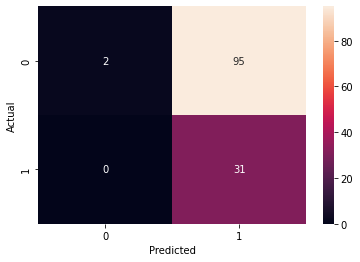

In [275]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [276]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04        97
           1       0.25      1.00      0.39        31

    accuracy                           0.26       128
   macro avg       0.62      0.51      0.22       128
weighted avg       0.82      0.26      0.13       128



In [277]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,2.532008e-08
1,rounds_funding_factor,-4.462318e-12
2,dp_rounds_count,-2.430770e-12
3,dp_rounds_amount_sum,1.629556e-07
4,dp_rounds_amount_max,-2.063513e-07
5,dp_last_round_amount,4.576197e-08
6,dp_years_operating,-8.002982e-13
7,sum_manager_exp,-8.389006e-13
8,sum_clevel_exp,-1.059445e-12
9,sum_engineering_exp,-4.403070e-13


### Standard

In [278]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.more50_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more50_employees, Length: 510, dtype: int6

In [279]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

In [280]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [281]:
# 4. Train your model and define your prediction variable

classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [282]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_train, y_train)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.856020942408377
Testing Data Score: 0.8359375


Predicted   0   1
Actual           
0          92   5
1          16  15


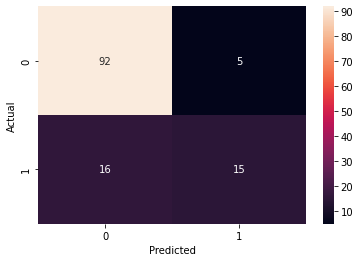

In [283]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [284]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90        97
           1       0.75      0.48      0.59        31

    accuracy                           0.84       128
   macro avg       0.80      0.72      0.74       128
weighted avg       0.83      0.84      0.82       128



In [285]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,0.827989
1,rounds_funding_factor,-0.013888
2,dp_rounds_count,-0.273207
3,dp_rounds_amount_sum,1.416360
4,dp_rounds_amount_max,-0.428625
5,dp_last_round_amount,1.602127
6,dp_years_operating,0.635808
7,sum_manager_exp,0.065849
8,sum_clevel_exp,0.145490
9,sum_engineering_exp,-0.677749


### Standard and oversampled balance

In [286]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.more50_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more50_employees, Length: 510, dtype: int6

In [287]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Over sampling

In [288]:
# Making balance w/over sampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification

X_train=np.array(X_train)

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 294), (1, 294)]


Modeling

In [289]:
X_resampled = pd.DataFrame(X_resampled)

In [290]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [291]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [292]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.8282312925170068
Testing Data Score: 0.765625


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted   0   1
Actual           
0          82  15
1          15  16


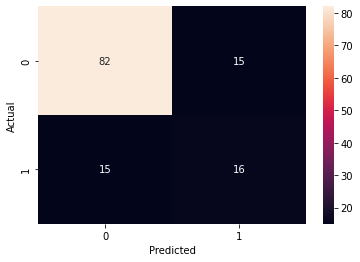

In [293]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [294]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        97
           1       0.52      0.52      0.52        31

    accuracy                           0.77       128
   macro avg       0.68      0.68      0.68       128
weighted avg       0.77      0.77      0.77       128



In [295]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,1.855751
1,rounds_funding_factor,-0.037206
2,dp_rounds_count,-0.313553
3,dp_rounds_amount_sum,1.823712
4,dp_rounds_amount_max,-0.670695
5,dp_last_round_amount,1.931342
6,dp_years_operating,0.594697
7,sum_manager_exp,0.040522
8,sum_clevel_exp,0.165442
9,sum_engineering_exp,-0.813897


### Standard and undersampled balance

In [296]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.more50_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more50_employees, Length: 510, dtype: int6

In [297]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Under sampling

In [298]:
# Making balance w/under sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification

X_train=np.array(X_train)

ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 88), (1, 88)]


Modeling

In [299]:
X_resampled = pd.DataFrame(X_resampled)

In [300]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [301]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [302]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.8295454545454546
Testing Data Score: 0.734375


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted   0   1
Actual           
0          78  19
1          15  16


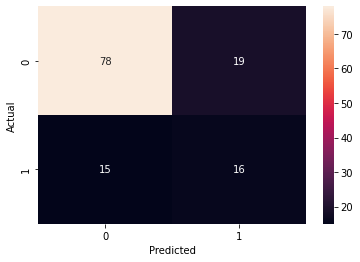

In [303]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [304]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        97
           1       0.46      0.52      0.48        31

    accuracy                           0.73       128
   macro avg       0.65      0.66      0.65       128
weighted avg       0.75      0.73      0.74       128



In [305]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,1.278294
1,rounds_funding_factor,0.020239
2,dp_rounds_count,-0.359856
3,dp_rounds_amount_sum,1.560949
4,dp_rounds_amount_max,1.099899
5,dp_last_round_amount,1.020138
6,dp_years_operating,0.457771
7,sum_manager_exp,0.117938
8,sum_clevel_exp,0.421434
9,sum_engineering_exp,-0.720550


### Standard and smote balance

In [306]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.more50_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more50_employees, Length: 510, dtype: int6

In [307]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Under sampling

In [308]:
# Making balance w/smote sampling
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

X_train=np.array(X_train)

X_resampled, y_resampled = SMOTE(random_state=1,sampling_strategy='auto').fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 294), (1, 294)]


Modeling

In [309]:
X_resampled = pd.DataFrame(X_resampled)

In [310]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [311]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [312]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.8333333333333334
Testing Data Score: 0.78125


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted   0   1
Actual           
0          81  16
1          12  19


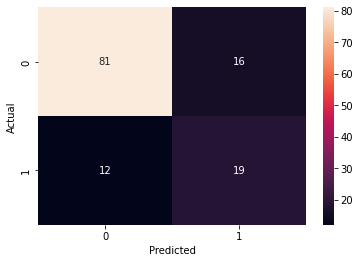

In [313]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [314]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85        97
           1       0.54      0.61      0.58        31

    accuracy                           0.78       128
   macro avg       0.71      0.72      0.71       128
weighted avg       0.79      0.78      0.79       128



In [315]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,2.200103
1,rounds_funding_factor,-0.137088
2,dp_rounds_count,-0.443428
3,dp_rounds_amount_sum,1.879768
4,dp_rounds_amount_max,-0.509349
5,dp_last_round_amount,2.397680
6,dp_years_operating,0.655620
7,sum_manager_exp,0.121408
8,sum_clevel_exp,0.297338
9,sum_engineering_exp,-0.945858


## More than 100 employees

### Original

In [316]:
# 1. Define variables X and y

X = X_columns # Independent
y = db_companies_Encode_Model.more100_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0           1400000  ...                                          15
1             10500  ...                                           9
2            200000  ...                                           2
3            150000  ...                                           4
4             20000  ...                                           0
..              ...  ...                                         ...
505          750000  ...                                          11
506       225000000  ...                                           8
507          130000  ...                                           4
508          130000  ...                                           3
509         4900000  ...                                           7

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more100_employees, Length: 510, dtype: int

In [317]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

In [318]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [319]:
# 4. Train your model and define your prediction variable

classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [320]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_train, y_train)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.15968586387434555
Testing Data Score: 0.1484375


Predicted  0    1
Actual           
0          2  109
1          0   17


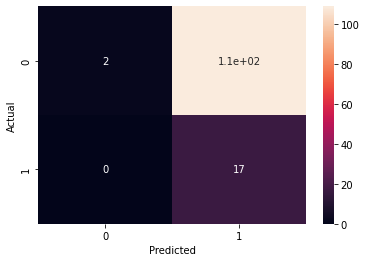

In [321]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [322]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       111
           1       0.13      1.00      0.24        17

    accuracy                           0.15       128
   macro avg       0.57      0.51      0.14       128
weighted avg       0.89      0.15      0.06       128



In [323]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,5.638901e-09
1,rounds_funding_factor,-2.307016e-12
2,dp_rounds_count,-1.424158e-12
3,dp_rounds_amount_sum,7.705679e-08
4,dp_rounds_amount_max,-9.435736e-08
5,dp_last_round_amount,2.260699e-08
6,dp_years_operating,-5.040860e-13
7,sum_manager_exp,-4.972631e-13
8,sum_clevel_exp,-6.275318e-13
9,sum_engineering_exp,-2.135980e-13


### Standard

In [324]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.more100_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more100_employees, Length: 510, dtype: int

In [325]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

In [326]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [327]:
# 4. Train your model and define your prediction variable

classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [328]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_train, y_train)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.918848167539267
Testing Data Score: 0.9140625


Predicted    0   1
Actual            
0          106   5
1            6  11


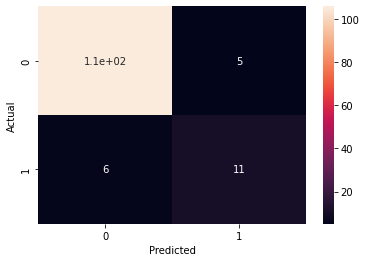

In [329]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [330]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       111
           1       0.69      0.65      0.67        17

    accuracy                           0.91       128
   macro avg       0.82      0.80      0.81       128
weighted avg       0.91      0.91      0.91       128



In [331]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,0.505580
1,rounds_funding_factor,0.167998
2,dp_rounds_count,-0.460997
3,dp_rounds_amount_sum,1.465468
4,dp_rounds_amount_max,-0.096362
5,dp_last_round_amount,1.634085
6,dp_years_operating,1.021096
7,sum_manager_exp,0.042070
8,sum_clevel_exp,0.146683
9,sum_engineering_exp,-0.619990


### Standard and oversampled balance

In [332]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.more100_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more100_employees, Length: 510, dtype: int

In [333]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Over sampling

In [334]:
# Making balance w/over sampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification

X_train=np.array(X_train)

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 326), (1, 326)]


Modeling

In [335]:
X_resampled = pd.DataFrame(X_resampled)

In [336]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [337]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [338]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.8665644171779141
Testing Data Score: 0.8125


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted   0   1
Actual           
0          91  20
1           4  13


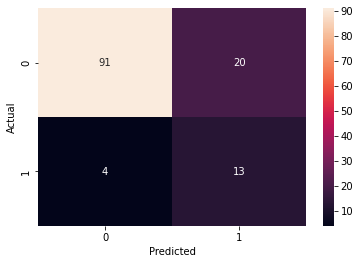

In [339]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [340]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       111
           1       0.39      0.76      0.52        17

    accuracy                           0.81       128
   macro avg       0.68      0.79      0.70       128
weighted avg       0.88      0.81      0.84       128



In [341]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,0.988889
1,rounds_funding_factor,0.039619
2,dp_rounds_count,-0.447714
3,dp_rounds_amount_sum,2.079574
4,dp_rounds_amount_max,-0.546233
5,dp_last_round_amount,2.199613
6,dp_years_operating,0.922976
7,sum_manager_exp,-0.203868
8,sum_clevel_exp,0.300494
9,sum_engineering_exp,-0.955163


### Standard and undersampled balance

In [342]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.more100_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more100_employees, Length: 510, dtype: int

In [343]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Under sampling

In [344]:
# Making balance w/over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification

X_train=np.array(X_train)

ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 56), (1, 56)]


Modeling

In [345]:
X_resampled = pd.DataFrame(X_resampled)

In [346]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [347]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [348]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.9107142857142857
Testing Data Score: 0.7734375


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted   0   1
Actual           
0          87  24
1           5  12


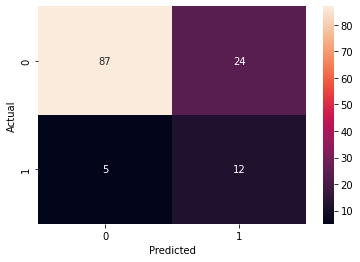

In [349]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [350]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       111
           1       0.33      0.71      0.45        17

    accuracy                           0.77       128
   macro avg       0.64      0.74      0.65       128
weighted avg       0.86      0.77      0.80       128



In [351]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,1.132416
1,rounds_funding_factor,0.174003
2,dp_rounds_count,-0.178362
3,dp_rounds_amount_sum,1.374500
4,dp_rounds_amount_max,0.879122
5,dp_last_round_amount,1.631535
6,dp_years_operating,0.804978
7,sum_manager_exp,0.056317
8,sum_clevel_exp,0.541781
9,sum_engineering_exp,-1.233802


### Standard and smote balance

In [388]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.more100_employees # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    1
506    1
507    0
508    0
509    0
Name: more100_employees, Length: 510, dtype: int

In [389]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Under sampling

In [390]:
# Making balance w/smote sampling
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

X_train=np.array(X_train)

X_resampled, y_resampled = SMOTE(random_state=1,sampling_strategy='auto').fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 326), (1, 326)]


Modeling

In [391]:
X_resampled = pd.DataFrame(X_resampled)

In [392]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [393]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [394]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.8834355828220859
Testing Data Score: 0.8125


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted   0   1
Actual           
0          92  19
1           5  12


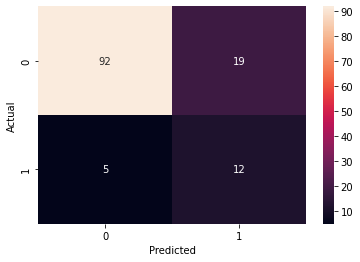

In [395]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [396]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.88       111
           1       0.39      0.71      0.50        17

    accuracy                           0.81       128
   macro avg       0.67      0.77      0.69       128
weighted avg       0.87      0.81      0.83       128



In [397]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,1.610383
1,rounds_funding_factor,0.038972
2,dp_rounds_count,-0.662945
3,dp_rounds_amount_sum,2.168248
4,dp_rounds_amount_max,-0.474412
5,dp_last_round_amount,2.453691
6,dp_years_operating,1.112384
7,sum_manager_exp,-0.096682
8,sum_clevel_exp,0.185802
9,sum_engineering_exp,-1.211710


## Soonicorn

### Original

In [352]:
# 1. Define variables X and y

X = X_columns # Independent
y = db_companies_Encode_Model.soonicorn # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0           1400000  ...                                          15
1             10500  ...                                           9
2            200000  ...                                           2
3            150000  ...                                           4
4             20000  ...                                           0
..              ...  ...                                         ...
505          750000  ...                                          11
506       225000000  ...                                           8
507          130000  ...                                           4
508          130000  ...                                           3
509         4900000  ...                                           7

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    0
506    1
507    0
508    0
509    0
Name: soonicorn, Length: 510, dtype: int64


In [353]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

In [354]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [355]:
# 4. Train your model and define your prediction variable

classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [356]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_train, y_train)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.07591623036649214
Testing Data Score: 0.1015625


Predicted    1
Actual        
0          115
1           13


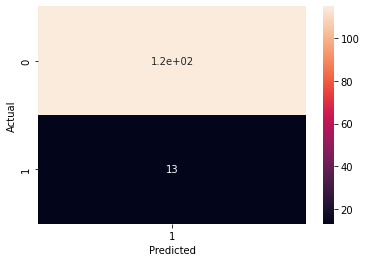

In [357]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [358]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.10      1.00      0.18        13

    accuracy                           0.10       128
   macro avg       0.05      0.50      0.09       128
weighted avg       0.01      0.10      0.02       128



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [359]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,2.536416e-09
1,rounds_funding_factor,-1.936985e-12
2,dp_rounds_count,-1.267412e-12
3,dp_rounds_amount_sum,-4.093239e-10
4,dp_rounds_amount_max,4.849404e-08
5,dp_last_round_amount,-3.864733e-08
6,dp_years_operating,-6.074335e-13
7,sum_manager_exp,-4.179387e-13
8,sum_clevel_exp,-5.498104e-13
9,sum_engineering_exp,-1.493365e-13


### Standard

In [360]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.soonicorn # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    0
506    1
507    0
508    0
509    0
Name: soonicorn, Length: 510, dtype: int64


In [361]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

In [362]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [363]:
# 4. Train your model and define your prediction variable

classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
y_pred

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [364]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_train, y_train)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.9790575916230366
Testing Data Score: 0.9765625


Predicted    0   1
Actual            
0          114   1
1            2  11


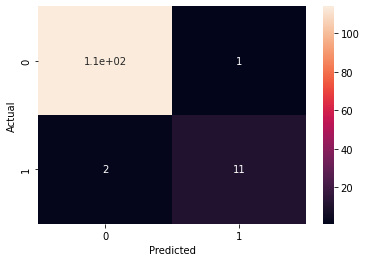

In [365]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [366]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       115
           1       0.92      0.85      0.88        13

    accuracy                           0.98       128
   macro avg       0.95      0.92      0.93       128
weighted avg       0.98      0.98      0.98       128



In [367]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,0.956566
1,rounds_funding_factor,-0.469355
2,dp_rounds_count,-0.000223
3,dp_rounds_amount_sum,1.595275
4,dp_rounds_amount_max,1.695732
5,dp_last_round_amount,0.929711
6,dp_years_operating,-0.449493
7,sum_manager_exp,0.291512
8,sum_clevel_exp,0.074364
9,sum_engineering_exp,0.202618


### Standard and oversampled balance

In [368]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.soonicorn # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    0
506    1
507    0
508    0
509    0
Name: soonicorn, Length: 510, dtype: int64


In [369]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Over sampling

In [370]:
# Making balance w/over sampling
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification

X_train=np.array(X_train)

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 353), (1, 353)]


Modeling

In [371]:
X_resampled = pd.DataFrame(X_resampled)

In [372]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [373]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [374]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.9376770538243626
Testing Data Score: 0.9453125


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted    0   1
Actual            
0          110   5
1            2  11


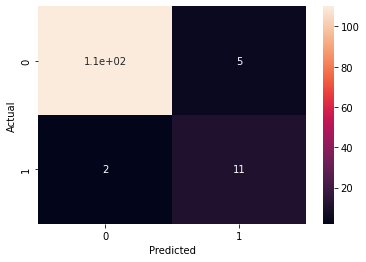

In [375]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [376]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       115
           1       0.69      0.85      0.76        13

    accuracy                           0.95       128
   macro avg       0.83      0.90      0.86       128
weighted avg       0.95      0.95      0.95       128



In [377]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,3.863241
1,rounds_funding_factor,-1.173786
2,dp_rounds_count,-0.244634
3,dp_rounds_amount_sum,2.604460
4,dp_rounds_amount_max,1.940179
5,dp_last_round_amount,1.251383
6,dp_years_operating,-0.977506
7,sum_manager_exp,0.584278
8,sum_clevel_exp,0.043689
9,sum_engineering_exp,0.284414


### Standard and undersampled balance

In [378]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.soonicorn # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    0
506    1
507    0
508    0
509    0
Name: soonicorn, Length: 510, dtype: int64


In [379]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Under sampling

In [380]:
# Making balance w/over sampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification

X_train=np.array(X_train)

ros = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 29), (1, 29)]


Modeling

In [381]:
X_resampled = pd.DataFrame(X_resampled)

In [382]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [383]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [384]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.9482758620689655
Testing Data Score: 0.9140625


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted    0   1
Actual            
0          106   9
1            2  11


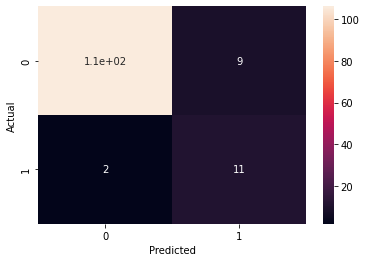

In [385]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [386]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       115
           1       0.55      0.85      0.67        13

    accuracy                           0.91       128
   macro avg       0.77      0.88      0.81       128
weighted avg       0.94      0.91      0.92       128



In [387]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,0.789428
1,rounds_funding_factor,-0.645300
2,dp_rounds_count,-0.229378
3,dp_rounds_amount_sum,1.209764
4,dp_rounds_amount_max,1.267800
5,dp_last_round_amount,0.909009
6,dp_years_operating,-0.450036
7,sum_manager_exp,0.441822
8,sum_clevel_exp,-0.037647
9,sum_engineering_exp,-0.229395


### Standard and smote balance

In [408]:
# 1. Define variables X and y

X = X_columns_standard # Independent
y = db_companies_Encode_Model.soonicorn # Dependent

print(X)
print(y)

     first_r_amount  ...  sum_dp_years_of_experience_as_entreprenuer
0         -0.077119  ...                                    1.164139
1         -0.131298  ...                                    0.341445
2         -0.123909  ...                                   -0.618365
3         -0.125859  ...                                   -0.344133
4         -0.130928  ...                                   -0.892596
..              ...  ...                                         ...
505       -0.102464  ...                                    0.615676
506        8.641500  ...                                    0.204329
507       -0.126639  ...                                   -0.344133
508       -0.126639  ...                                   -0.481249
509        0.059353  ...                                    0.067214

[510 rows x 22 columns]
0      0
1      0
2      0
3      1
4      0
      ..
505    0
506    1
507    0
508    0
509    0
Name: soonicorn, Length: 510, dtype: int64


In [409]:
# 2. Split the data

from sklearn.model_selection import train_test_split

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4281)

Under sampling

In [410]:
# Making balance w/smote sampling
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

X_train=np.array(X_train)

X_resampled, y_resampled = SMOTE(random_state=1,sampling_strategy='auto').fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 353), (1, 353)]


Modeling

In [411]:
X_resampled = pd.DataFrame(X_resampled)

In [412]:
# 3. Choose your Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [413]:
# 4. Train your model and define your prediction variable

classifier.fit(X_resampled, y_resampled)
y_pred=classifier.predict(X_test)
y_pred

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [414]:
# 5. Statistics for your model

# Scores for model
training_score = classifier.score(X_resampled, y_resampled)
testing_score = classifier.score(X_test, y_test)

print(f"Training Data Score: {training_score}")
print(f"Testing Data Score: {testing_score}")

Training Data Score: 0.9589235127478754
Testing Data Score: 0.9609375


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Predicted    0   1
Actual            
0          112   3
1            2  11


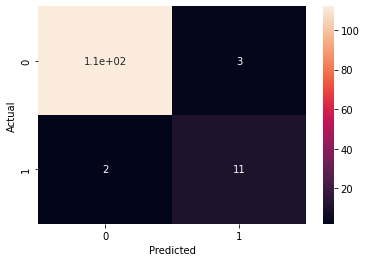

In [415]:
# 6. Confusion matrix

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

In [416]:
# 7. Accuracy 

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       115
           1       0.79      0.85      0.81        13

    accuracy                           0.96       128
   macro avg       0.88      0.91      0.90       128
weighted avg       0.96      0.96      0.96       128



In [417]:
# 8. Importances by variable

importances = pd.DataFrame(data={
    'Attribute': X_columns.columns,
    'Importance': classifier.coef_[0]
})
importances

,Attribute,Importance
0,first_r_amount,3.293818
1,rounds_funding_factor,-1.003990
2,dp_rounds_count,-0.310149
3,dp_rounds_amount_sum,2.725479
4,dp_rounds_amount_max,2.613053
5,dp_last_round_amount,0.978870
6,dp_years_operating,-0.988681
7,sum_manager_exp,0.699812
8,sum_clevel_exp,0.158069
9,sum_engineering_exp,0.169714
